# Information Retrieval project: Recommender Systems

**Authors**

- Bibian Bennink (s1002645)
- Sven Berberich (s1006248)
- Niek Derksen (s4363779)

**Project Goal Description**

In this project, you will implement popularity-based, feature-based and collaborative filtering recommendation algorithms. You will then train and evaluate the resulting algorithms on publicly available dataset\(s\), contrasting the performance and the recommendations of your models. Finally, you will reflect on your findings; e.g., discuss the limitations of your algorithms, how well they are suited for your chosen data and outline any possible future research directions.

**Algorithms**

The following algorithems were chosen:

- Popularity-based/Community Based - True Bayesian Estimate
- Feature-based - Genre based Vector Space Model
- Collaborative Filtering - truncated Singular Value Decomposition

**Evaluation**

The following evaluation techniques are used:

- NCDG
- Wilcoxon signed rank test
- Wilcoxon signed sum test

In [19]:
# Data exploration
# file description: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ranksums

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD

# Data loading

In [20]:
movie_df = pd.read_csv("data/MovieLens/movies.dat", sep="::", engine="python", encoding = 'unicode_escape', header=None, names=["movie_id", "title", "genres"])
movie_df['genres'] = movie_df['genres'].map(lambda gs: gs.split('|'))   # Split genres string into a list of genres
movie_df['release_year'] = movie_df['title'].map(lambda title: int(re.findall("\(([0-9]{4})\)$", title)[0]))    # Extraxt release years into seperate column
movie_df = movie_df.set_index('movie_id')

# Represent each Genre in a binary representation
all_genres = []

for genre_list in movie_df['genres']:
    for genre in genre_list:
        if genre not in all_genres:
            all_genres.append(genre)
all_genres.sort()

genre_df = pd.DataFrame(columns=["movie_id"] + all_genres)

for index, movie in movie_df.iterrows():
    row = []
    for genre in all_genres:
        row.append(int(genre in movie['genres']))

    genre_df.loc[len(genre_df.index)] = [index] + row

genre_df = genre_df.set_index('movie_id')

movie_genre_df = movie_df.join(genre_df)
movie_genre_df

,title,genres,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),"[Comedy, Drama]",1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II (1995),[Comedy],1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,Meet the Parents (2000),[Comedy],2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3949,Requiem for a Dream (2000),[Drama],2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3950,Tigerland (2000),[Drama],2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
number_occupation_map = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

user_df = pd.read_csv("data/MovieLens/users.dat", sep="::", engine="python", header=None, names=["user_id", "sex", "age", "occupation", "zipcode"])
user_df["occupation_name"] = user_df["occupation"].map(lambda occ: number_occupation_map[occ]) # map occupation ids to their names
user_df = user_df.set_index('user_id')

user_df

,sex,age,occupation,zipcode,occupation_name
user_id,,,,,
1,F,1,10,48067,K-12 student
2,M,56,16,70072,self-employed
3,M,25,15,55117,scientist
4,M,45,7,02460,executive/managerial
5,M,25,20,55455,writer
...,...,...,...,...,...
6036,F,25,15,32603,scientist
6037,F,45,1,76006,academic/educator
6038,F,56,1,14706,academic/educator


In [22]:
from datetime import datetime, timezone

ratings_df = pd.read_csv("data/MovieLens/ratings.dat", sep="::", engine="python", header=None, names=["user_id", "movie_id", "rating", "timestamp"])
ratings_df['datetime'] = ratings_df['timestamp'].map(lambda t: datetime.fromtimestamp(t, timezone.utc))

ratings_df

,user_id,movie_id,rating,timestamp,datetime
0,1,1193,5,978300760,2000-12-31 22:12:40+00:00
1,1,661,3,978302109,2000-12-31 22:35:09+00:00
2,1,914,3,978301968,2000-12-31 22:32:48+00:00
3,1,3408,4,978300275,2000-12-31 22:04:35+00:00
4,1,2355,5,978824291,2001-01-06 23:38:11+00:00
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41+00:00
1000205,6040,1094,5,956704887,2000-04-25 23:21:27+00:00
1000206,6040,562,5,956704746,2000-04-25 23:19:06+00:00
1000207,6040,1096,4,956715648,2000-04-26 02:20:48+00:00


In [23]:
user_ratings_df = ratings_df.join(user_df, on="user_id") # ratings + users
movie_ratings_df = ratings_df.join(movie_genre_df, on="movie_id") # ratings + movies
joined_df = user_ratings_df.join(movie_genre_df, on="movie_id") # ratings + movies + users

joined_df

,user_id,movie_id,rating,timestamp,datetime,sex,age,occupation,zipcode,occupation_name,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,2000-12-31 22:12:40+00:00,F,1,10,48067,K-12 student,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3,978302109,2000-12-31 22:35:09+00:00,F,1,10,48067,K-12 student,...,0,0,0,1,0,0,0,0,0,0
2,1,914,3,978301968,2000-12-31 22:32:48+00:00,F,1,10,48067,K-12 student,...,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,978300275,2000-12-31 22:04:35+00:00,F,1,10,48067,K-12 student,...,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,978824291,2001-01-06 23:38:11+00:00,F,1,10,48067,K-12 student,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41+00:00,M,25,6,11106,doctor/health care,...,0,0,0,0,0,0,0,0,0,0
1000205,6040,1094,5,956704887,2000-04-25 23:21:27+00:00,M,25,6,11106,doctor/health care,...,0,0,0,0,0,1,0,0,1,0
1000206,6040,562,5,956704746,2000-04-25 23:19:06+00:00,M,25,6,11106,doctor/health care,...,0,0,0,0,0,0,0,0,0,0
1000207,6040,1096,4,956715648,2000-04-26 02:20:48+00:00,M,25,6,11106,doctor/health care,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def split_data(dataframe, train_ratio=0.8, shuffle=False):

    train_index_array = []
    test_index_array = []

    for user_id in dataframe['user_id'].unique():
        user_df = dataframe[dataframe['user_id'] == user_id]

        if shuffle:
            user_df = user_df.sample(frac=1)

        train_index_array = np.concatenate([train_index_array, user_df.iloc[:int(len(user_df)*train_ratio), :].index])
        test_index_array = np.concatenate([test_index_array, user_df.iloc[int(len(user_df)*train_ratio):, :].index])

    train_df = dataframe.loc[train_index_array]
    test_df = dataframe.loc[test_index_array]

    return train_df, test_df

In [25]:
train_df, test_df = split_data(joined_df, 0.8, True)

# Data inspection

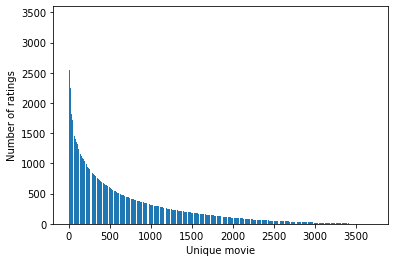

In [8]:
number_movie_ratings = ratings_df.groupby('movie_id')['user_id'].nunique()
number_movie_ratings = number_movie_ratings.sort_values(ascending=False)
plt.bar(range(len(number_movie_ratings)), number_movie_ratings)
plt.xlabel("Unique movie")
plt.ylabel("Number of ratings")
plt.savefig("graphs/number_of_ratings_per_movie.pdf", bbox_inches="tight")
plt.show()

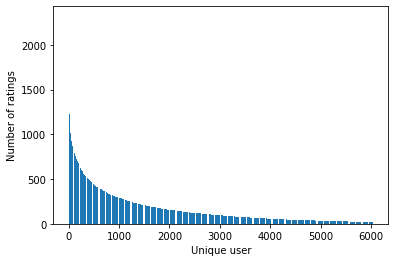

In [31]:
number_user_ratings = ratings_df.groupby('user_id')['movie_id'].nunique()
number_user_ratings = number_user_ratings.sort_values(ascending=False)
plt.bar(range(len(number_user_ratings)), number_user_ratings)
plt.xlabel("Unique user")
plt.ylabel("Number of ratings")
plt.savefig("graphs/number_of_ratings_per_user.pdf", bbox_inches="tight")
plt.show()

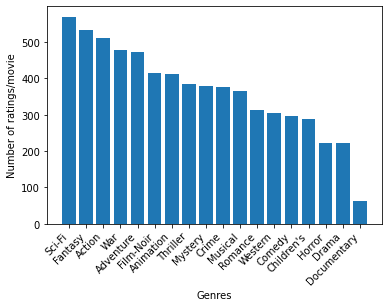

In [32]:
ratings_per_genre = []
movies_per_genre = []
for genre in all_genres:
    ratings_per_genre.append(np.sum(joined_df[genre]))
    movies_per_genre.append(np.sum(movie_genre_df[genre]))

all_genres = np.array(all_genres)
ratings_per_genre = np.array(ratings_per_genre)
movies_per_genre = np.array(movies_per_genre)

order = np.argsort(ratings_per_genre)[::-1]

plt.bar(all_genres[order], ratings_per_genre[order])
plt.xlabel("Genres")
plt.ylabel("Number of ratings")
plt.xticks(rotation=45, ha='right')
plt.savefig("graphs/ratings_per_genre.pdf", bbox_inches="tight")
plt.show()

order = np.argsort(movies_per_genre)[::-1]

plt.bar(all_genres[order], movies_per_genre[order])
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha='right')
plt.savefig("graphs/movies_per_genre.pdf", bbox_inches="tight")
plt.show()

order = np.argsort((ratings_per_genre / movies_per_genre))[::-1]

plt.bar(all_genres[order], (ratings_per_genre / movies_per_genre)[order])
plt.xlabel("Genres")
plt.ylabel("Number of ratings/movie")
plt.xticks(rotation=45, ha='right')
plt.savefig("graphs/ratings_per_movie_per_genre.pdf", bbox_inches="tight")
plt.show()


# Models

In [17]:
import abc

class IRecommenderModel(object, metaclass=abc.ABCMeta):
    def __init__(self):
        pass

    @abc.abstractmethod
    def fit(self, dataframe):
        raise NotImplementedError("User of this abstract class must implement this method.")

    @abc.abstractmethod
    def predict(self, dataframe, k):
        raise NotImplementedError("User of this abstract class must implement this method.")

## Feature based model - Genre based Vector Space Model 

In [18]:
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

class GenreVSM(IRecommenderModel):
    def __init__(self, genre_cols):
        super().__init__()
        self.genre_cols = genre_cols
        self.users_profiles = dict()

    def fit(self, dataframe):
        self.learn_profiles(dataframe)

    def predict(self, dataframe, k):
        user_movies_dict = self.analyze_content(dataframe)

        predictions = dict()

        for user_id, movies_dict in user_movies_dict.items():
            order = self.filter_components(movies_dict['vector'], user_id)
            predictions[user_id] = list(movies_dict['movie_ids'][order][:k])
        
        return predictions

        
    def analyze_content(self, dataframe):
        user_movies_dict = dict()

        for user_id in dataframe['user_id'].unique():
            user_movies_dict[user_id] = {
                'vector': dataframe[dataframe['user_id'] == user_id].to_numpy()[:, -len(self.genre_cols):].astype(int),  # TODO should i normalize here???
                'movie_ids': dataframe[dataframe['user_id'] == user_id]['movie_id'].to_numpy()
            }

        return user_movies_dict


    def learn_profiles(self, dataframe):
        
        for user_id in dataframe['user_id'].unique():
            numpy_user = dataframe[dataframe['user_id'] == user_id].to_numpy()

            user_vector = (numpy_user[:, -len(self.genre_cols):].astype(int) * (numpy_user[:, 2] - 3)[:, None]).sum(axis=0)
            user_vector = normalize_vector(user_vector.astype(float))  # TODO should i even normalize here???

            self.users_profiles[user_id] = user_vector

    def filter_components(self, movie_vectors, user_id):
        res = []
        user_vector = self.users_profiles[user_id]

        for m_vector in movie_vectors:
            res.append(cos_sim(user_vector, m_vector))

        return np.argsort(res)

## Popularity based model - True Bayesian estimate


$
     WR = \frac{v}{v + m} * R + \frac{m}{v+m} * C
$ 

where:
-  $v$ is the number of votes for a movie, 
-  $m$ is the minimum votes required to be in the top 250 movies, 
-  $R$ is the average movie rating and 
-  $C$ the mean vote across the whole report.

In [19]:
class TrueBayesianEstimate(IRecommenderModel):

    def __init__(self):
        super().__init__()
        pass
    
    def predict(self, dataframe, k):
        users = dataframe['user_id'].unique()
        movies = dataframe['movie_id']
        predictions = dict()
        TBE_data = self.TBE_df.sort_values('score', ascending=False)
        for user in users:
            movie_per_user = dataframe.loc[dataframe['user_id'] == user, 'movie_id']
            pred = TBE_data[TBE_data["movie_id"].isin(movie_per_user)]
            predictions[user] = list(pred['movie_id'].head(k+1))
        return predictions

    
    def fit(self, dataframe):
        self.TBE_df = self.create_df(dataframe)
        
        # 80% quantile for now
        m = self.TBE_df['nr_occ'].quantile(0.8)
        C = self.TBE_df['avg_rating'].mean()
        self.TBE_df = self.TBE_df[self.TBE_df['nr_occ'] >= m]

        self.TBE_df['score'] = self.true_bayesian_estimate(self.TBE_df,m,C) 
    
    def create_df(self, dataframe):
        all_movies = dataframe['movie_id'].to_numpy()
        unique_movies = dataframe['movie_id'].unique()
        all_ratings = dataframe['rating'].to_numpy()
        
        TBE_data = np.empty(shape=[len(unique_movies),3])

        for idx, movie_id in enumerate(unique_movies):
            movie_count = np.where(all_movies==movie_id)
            nr_occ = len(movie_count[0])
            ratings = all_ratings[movie_count]
            avg_rating = ratings.mean()
            TBE_data[idx]=[movie_id, nr_occ, avg_rating]
        
        TBE_df = pd.DataFrame(TBE_data, columns=['movie_id', 'nr_occ', 'avg_rating'])
        return TBE_df

    def true_bayesian_estimate(self, movies, m, C):
        v = movies['nr_occ']
        R = movies['avg_rating']
        return (v/(v+m)*R) + (m/(v+m)*C)

## Collaborative filtering - dot multiplication of latent movie and user rating vectors

In [20]:
class CollaborativeTruncatedSVD(IRecommenderModel):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim     
        self.movie_SVD = TruncatedSVD(n_components=self.dim)
    
    def fit(self, dataFrame):
        pivot = pd.pivot_table(train_df, values='rating', index=['user_id'], columns=['movie_id'], fill_value=0)
        self.userid_to_index = pivot.index
        self.latent_users = TruncatedSVD(n_components=self.dim).fit_transform(pivot)
                    
        temp_df = dataFrame[['movie_id', 'age', 'sex', 'release_year'] + all_genres].copy()
        temp_df['sex'] = temp_df['sex'].map(lambda s: s == 'F')
        grouped = temp_df.groupby(by='movie_id').mean()

        for genre in all_genres:
            grouped[genre] = temp_df.groupby(by='movie_id')[genre].mean()
        
        latent_grouped = self.movie_SVD.fit_transform(grouped)

        regressor_df = pd.DataFrame()
        regressor_df['user_vector'] = dataFrame['user_id'].map(lambda id: self.latent_users[pivot.index == id][0])
        regressor_df['movie_vector'] = dataFrame['movie_id'].map(lambda id: latent_grouped[grouped.index == id][0])

        target_df = dataFrame['rating']

        regressor_df['full_vector'] = regressor_df.apply(lambda row: np.concatenate((row['user_vector'], row['movie_vector'])), axis=1)

        data = np.zeros((len(regressor_df), self.dim*2))
        for i, row in enumerate(regressor_df.iterrows()):
            data[i, :] = row[1]['full_vector']

        self.regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, verbose=1)
        self.regressor.fit(data, target_df.to_numpy())     

        

    def predict(self, dataFrame, k):
        user_movies_dict = self.create_vectors(dataFrame)

        predictions = dict()

        for user_id, movies_dict in user_movies_dict.items():
            user_vector = self.latent_users[self.userid_to_index == user_id][0]

            data = np.concatenate([np.broadcast_to(user_vector, (movies_dict['vectors'].shape[0],self.dim)), movies_dict['vectors']], axis=1)
            prediction = self.regressor.predict(data)
            order = np.argsort(prediction)[::-1]

            predictions[user_id] = list(movies_dict['movie_ids'][order][:k])

        return predictions

    def create_vectors(self, dataframe):
        user_movies_dict = dict()

        for user_id in dataframe['user_id'].unique():
            
            relevant_movies = dataframe[dataframe['user_id'] == user_id]

            temp_df = relevant_movies[['movie_id', 'age', 'sex', 'release_year'] + all_genres].copy()
            temp_df['sex'] = temp_df['sex'].map(lambda s: s == 'F')
            grouped = temp_df.groupby(by='movie_id').mean()

            for genre in all_genres:
                grouped[genre] = temp_df.groupby(by='movie_id')[genre].mean()

            user_movies_dict[user_id] = {
                'vectors': self.movie_SVD.transform(grouped),
                'movie_ids': relevant_movies['movie_id'].to_numpy()
            }

        return user_movies_dict

# Evaluation

In [21]:
def DCG(query_relevancy_labels, k):
    res = 0
    # res = ((2 ** query_relevancy_labels[:k] - 1) / np.log(1 + (np.array(range(min(k, len(query_relevancy_labels)))) + 1), 2)).sum() # Untested numpy solution 
    for i in range(min(k,len(query_relevancy_labels))):
        res += (2 ** query_relevancy_labels[i] - 1) / (np.log2(1 + (i+1)))
    return res
    
def NDCG(query_relevancy_labels, k):
    dcg_value = DCG(query_relevancy_labels, k)
    idcg_value = DCG(sorted(query_relevancy_labels, reverse=True), k)
    return (dcg_value / idcg_value) if idcg_value > 0 else 0

def get_rating(user_id, movie_id, df):
    user_df = df[df["user_id"] == user_id]
    return int(user_df[user_df["movie_id"] == movie_id]["rating"])

In [22]:
def evaluate(train_df, test_df, name_model_tuples, k):
    model_dict = dict()
    for modelname, model in name_model_tuples:
        model.fit(train_df)
        print(f"Model \"{modelname}\" fitted.")

        predicted_dict = model.predict(test_df, k)
        print(f"Model \"{modelname}\" predicted.")

        ndcgs = dict()
        for user_id, movie_ids in predicted_dict.items():
            relevancy_lables = [get_rating(user_id, movie_id, test_df) for movie_id in movie_ids]
            ndcgs[user_id] = NDCG(relevancy_lables, k)

        model_dict[modelname] = ndcgs
        print(f"Model \"{modelname}\" evaluated.")

    return model_dict

In [23]:
def plot_results(res_dict):
    for method1 in res_dict.keys():
        for method2 in res_dict.keys():
            if method1 != method2:
                p = wilcoxon(list(res_dict[method1].values()), list(res_dict[method2].values()), alternative="greater").pvalue

                print(f"p-value of \"{method1}\" > \"{method2}\": \t {p}")

        print()

    for method in res_dict.keys():
        plt.hist(res_dict[method].values(), bins=50, density=True, alpha = 0.5, label=method)
    plt.legend()
    plt.show()

In [13]:
def split_by_reviews_given(res_dict, train_df, split=10):
    split_dict = dict()

    for method in res_dict.keys():
        below = []
        above = []

        method_dict = res_dict[method]

        for user_id in method_dict.keys():
            nr_reviews = len(train_df[train_df['user_id'] == user_id])

            if nr_reviews > split:
                above.append(method_dict[user_id])
            else:
                below.append(method_dict[user_id])

        split_dict[method] = {
            'below': below,
            'above': above
        }

    colors = {
        0: 'blue',
        1: 'orange',
        2: 'green'
    }

    for i, method1 in enumerate(split_dict.keys()):
        p = ranksums(split_dict[method1]['below'], split_dict[method1]['above']).pvalue

        below = split_dict[method1]['below']
        above = split_dict[method1]['above']

        fig = plt.figure(figsize=(7,3))
        ax = fig.add_subplot(111)

        ax.boxplot([below, above], vert = 0)
        ax.set_yticklabels(['Below average', 'Above average'])
        
        plt.title(f'{method1} $p \\approx {p:.4f}$ (RankSums)')
        plt.xlabel("NDCG")
        plt.tight_layout()
        plt.savefig(f"/data/notebook_files/graphs/{method1}_below_above.pdf")
        plt.show()


    
        for method2 in split_dict.keys():
            if method1 != method2:
                p = wilcoxon(split_dict[method1]['below'], split_dict[method2]['below']).pvalue

                below1 = split_dict[method1]['below']
                below2 = split_dict[method2]['below']

                plt.bar([f'{method1} n={len(below1)}', f'{method2} n={len(below2)}'], [np.mean(below1), np.mean(below2)], yerr=[np.std(below1), np.std(below2)], capsize=10, alpha=0.5, color=colors[i])
                plt.title(f'Below p={p} (Wilcoxon)')
                plt.show()

                p = wilcoxon(split_dict[method1]['above'], split_dict[method2]['above']).pvalue

                above1 = split_dict[method1]['above']
                above2 = split_dict[method2]['above']

                plt.bar([f'{method1} n={len(above1)}', f'{method2} n={len(above2)}'], [np.mean(above1), np.mean(above2)], yerr=[np.std(above1), np.std(above2)], capsize=10, alpha=0.5, color=colors[i])
                plt.title(f'Above p={p} (Wilcoxon)')
                plt.show()

    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(111)

    ax.boxplot([split_dict[method2]['below'] for method2 in res_dict.keys()], vert = 0)
    ax.set_yticklabels(['Genre VSM', 'True Bayesian\nEstimate', 'Collaborative\nfiltering model SVD'])
        
    plt.title(f'Below average number of users (average={split})')
    plt.xlabel("NDCG")
    plt.tight_layout()
    plt.savefig(f"/data/notebook_files/graphs/methods_below.pdf")
    plt.show()

    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(111)

    ax.boxplot([split_dict[method2]['above'] for method2 in res_dict.keys()], vert = 0)
    ax.set_yticklabels(['Genre VSM', 'True Bayesian\nEstimate', 'Collaborative\nfiltering model SVD'])
        
    plt.title(f'Above average number of users (average={split})')
    plt.xlabel("NDCG")
    plt.tight_layout()
    plt.savefig(f"/data/notebook_files/graphs/methods_above.pdf")
    plt.show()

      Iter       Train Loss   Remaining Time 
         1           1.2353            2.00m
         2           1.2244            2.02m
         3           1.2155            2.07m
         4           1.2083            2.08m
         5           1.2022            2.08m
         6           1.1970            2.05m
         7           1.1927            2.05m
         8           1.1891            2.04m
         9           1.1861            2.03m
        10           1.1835            2.01m
        20           1.1685            1.89m
        30           1.1619            1.80m
        40           1.1572            1.67m
        50           1.1529            1.55m
        60           1.1492            1.43m
        70           1.1456            1.31m
        80           1.1423            1.20m
        90           1.1392            1.10m
       100           1.1358           59.84s
       200           1.1081            0.00s
Model "dim=2 SVD" fitted.
Model "dim=2 SVD" predicted.

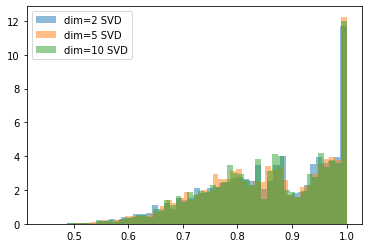

In [38]:
svd_train_df, svd_val_df = split_data(train_df, train_ratio=0.8, shuffle=True)

dims = [2,5,10]

svd_res_dict = evaluate(svd_train_df, svd_val_df, [(f"dim={dim} SVD", CollaborativeTruncatedSVD(dim)) for dim in dims], k=5)

plot_results(svd_res_dict)

Model "Genre VSM" fitted.
Model "Genre VSM" predicted.
Model "Genre VSM" evaluated.
Model "True Bayesian Estimate" fitted.
Model "True Bayesian Estimate" predicted.
Model "True Bayesian Estimate" evaluated.
      Iter       Train Loss   Remaining Time 
         1           1.2335            6.06m
         2           1.2210            6.14m
         3           1.2107            6.25m
         4           1.2019            6.09m
         5           1.1940            5.96m
         6           1.1876            5.85m
         7           1.1818            5.87m
         8           1.1771            5.89m
         9           1.1726            5.90m
        10           1.1688            5.91m
        20           1.1441            6.10m
        30           1.1304            9.15m
        40           1.1208            9.88m
        50           1.1141            9.99m
        60           1.1076            9.74m
        70           1.1018            8.65m
        80           1.0964

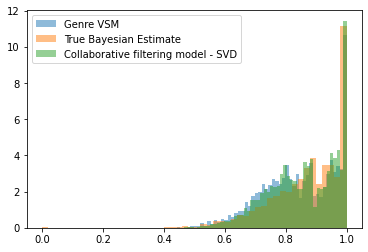

In [24]:

genre_vsm = ('Genre VSM', GenreVSM(all_genres))
true_bayesian = ('True Bayesian Estimate', TrueBayesianEstimate())
colab_svd = ('Collaborative filtering model - SVD', CollaborativeTruncatedSVD(5)) # TODO adjust to best working dimension parameter.
res_dict = evaluate(train_df, test_df, [genre_vsm, true_bayesian, colab_svd], k=5)

plot_results(res_dict)

In [6]:
# Save result dict to file.
import json
save_dict = dict()
for key, value in res_dict.items():
    save_dict[key] = dict()

    for id, ndcg in value.items():
        save_dict[key][int(id)] = ndcg

json_dict = json.dumps(save_dict)

# open file for writing, "w" 
f = open("/data/notebook_files/dict.json","w")

# write json object to file
f.write(json_dict)

# close file
f.close()

NameError: NameError: name 'res_dict' is not defined

In [9]:
# Load results from file
import json
with open('/data/notebook_files/dict.json') as json_file:
    loaded_res_dict = json.load(json_file)
    print(loaded_res_dict) # TODO userids are probably not ints but strings instead will probably break the ploting code.

res_dict = loaded_res_dict

{'Genre VSM': {'1': 0.8905043249628273, '2': 1.0, '3': 0.7592103877370563, '4': 0.9905390250586902, '5': 0.6911824510795137, '6': 0.9947849774998492, '7': 0.9334723839259147, '8': 0.9639021258532504, '9': 0.7334463884211522, '10': 0.8810000878444335, '11': 0.6048119392155099, '12': 0.7992196626514892, '13': 0.9370319343538683, '14': 0.7624044981458452, '15': 0.8332951803507741, '16': 0.8872222555927217, '17': 0.9702101316501444, '18': 0.75998993212803, '19': 0.9666054467748356, '20': 0.935976846914967, '21': 0.7595280241796497, '22': 0.9251630002926033, '23': 0.6339990776497688, '24': 0.8810000878444335, '25': 1.0, '26': 1.0, '27': 0.9026946615175333, '28': 1.0, '29': 0.7605871063257271, '30': 0.8364007171916706, '31': 0.9019520307580505, '32': 0.635869643206908, '33': 0.7238060694003194, '34': 0.9438249709709576, '35': 0.6480595160152164, '36': 0.8605811493628729, '37': 0.6929273254236049, '38': 0.8063820943256257, '39': 0.9309251075025486, '40': 1.0, '41': 0.8149306034638861, '42': 0

In [14]:
average_reviews = len(train_df) / len(train_df['user_id'].unique())

print(average_reviews)

split_by_reviews_given(loaded_res_dict, train_df, split=132)

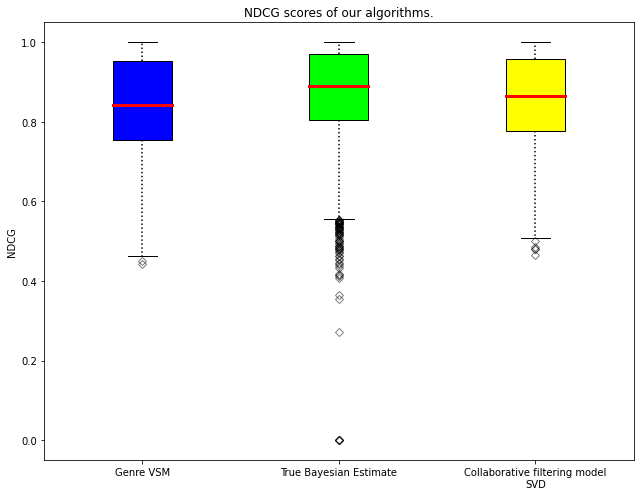

In [11]:
def plot_and_save(res_dict):

    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)

    bp = ax.boxplot([list(res_dict[method].values()) for method in res_dict.keys()], patch_artist=True)

    colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    for whisker in bp['whiskers']:
        whisker.set(linewidth = 1.5,
                    linestyle =":")

    for median in bp['medians']:
        median.set(color ='red',
                linewidth = 3)
        
    for flier in bp['fliers']:
        flier.set(marker ='D',
                color ='#e7298a',
                alpha = 0.5)
        
    ax.set_xticklabels(['Genre VSM', 'True Bayesian Estimate', 'Collaborative filtering model\nSVD'])
    plt.ylabel('NDCG')
    plt.title('NDCG scores of our algorithms.')
    plt.savefig('/data/notebook_files/graphs/main_results.pdf')
    plt.tight_layout()
    plt.show()   
    
plot_and_save(res_dict)

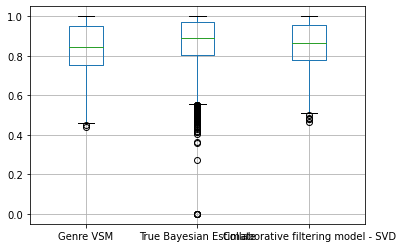

In [18]:
# fig = plt.figure(figsize=(9,7))
# ax = fig.add_subplot(111)
# bp = ax.boxplot([list(res_dict[method].values()) for method in res_dict.keys()], patch_artist=True)

# columns = ['Genre VSM','True Bayesian Estimate','Collaborative filtering model - SVD']
# outliers = pd.DataFrame([flier.get_ydata() for flier in bp["fliers"]])
# boxes = pd.DataFrame([box.get_ydata() for box in bp["boxes"]], columns=columns)
# medians = pd.DataFrame([median.get_ydata() for median in bp["medians"]], columns=columns)
# whiskers = pd.DataFrame([whiskers.get_ydata() for whiskers in bp["whiskers"]], columns=columns)

x = pd.DataFrame.from_dict(res_dict)
_, bp = pd.DataFrame.boxplot(x, return_type='both')

columns = ['Genre VSM','True Bayesian Estimate','Collaborative filtering model - SVD']
outliers = pd.DataFrame([flier.get_ydata() for flier in bp["fliers"]])
boxes = pd.DataFrame([box.get_ydata() for box in bp["boxes"]])
medians = pd.DataFrame([median.get_ydata() for median in bp["medians"]])
whiskers = pd.DataFrame([whiskers.get_ydata() for whiskers in bp["whiskers"]])

# outliers = pd.DataFrame(outliers.transpose(copy=True), columns=columns)
# boxes = pd.DataFrame(boxes.transpose(copy=True), columns=columns)
# medians = pd.DataFrame(medians.transpose(copy=True), columns=columns)
# whiskers = pd.DataFrame(whiskers.transpose(copy=True), columns=columns)

outliers